In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ( 
     accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


from xgboost import XGBClassifier
import xgboost as xgb
import joblib

In [3]:
# Load CSV with robust path handling

CANDIDATE_PATHS = [
    "../data/hypertension_cleaned.csv",
    "./data/hypertension_cleaned.csv",
    "./hypertension_cleaned.csv",
    "/mnt/data/hypertension_cleaned.csv"
]

for p in CANDIDATE_PATHS:
    if os.path.exists(p):
        data_path = p
        break
else:
    raise FileNotFoundError(f"Could not find hypertension_cleaned.csv in any of: {CANDIDATE_PATHS}")

data = pd.read_csv(data_path)
print(f"Loaded data from: {data_path} -> shape={data.shape}")

Loaded data from: ../data/hypertension_cleaned.csv -> shape=(8835, 7)


In [4]:
data.head()

,Age,BMI,Systolic_BP,Diastolic_BP,Heart_Rate,Gender,Hypertension
0,83,16.6,156,63,91,Male,High
1,37,38.7,102,85,51,Male,High
2,73,26.4,92,102,50,Male,High
3,65,17.3,100,84,75,Female,High
4,85,25.7,177,64,93,Female,High


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8835 entries, 0 to 8834
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           8835 non-null   int64  
 1   BMI           8835 non-null   float64
 2   Systolic_BP   8835 non-null   int64  
 3   Diastolic_BP  8835 non-null   int64  
 4   Heart_Rate    8835 non-null   int64  
 5   Gender        8835 non-null   object 
 6   Hypertension  8835 non-null   object 
dtypes: float64(1), int64(4), object(2)
memory usage: 483.3+ KB


In [6]:
data.shape

(8835, 7)

### Basic Data Cleaning & Quick Sanity checks

In [7]:
# Creating a copy of the data
df = data.copy()

In [8]:
# Converting target columns to binary
assert 'Hypertension' in df.columns, 'Expected a "Hypertension" column'

df['Hypertension'] = (
    df['Hypertension']
    .str.strip()
    .str.capitalize()
    .map({'Low': 0, 'High': 1})
)

In [9]:
df['Gender'] = (
    df['Gender']
    .map({'Male' : 1, 'Female': 0})
)

In [10]:
# Check for unmapped values in hypertension column
if df['Hypertension'].isna().any():
    raise ValueError("Hypertension column contains unexpected values")

df['Hypertension'] = df['Hypertension'].astype(int)

In [11]:
# Check for unmapped values in Gender column
if df['Gender'].isna().any():
    raise ValueError('Gender column contains unexpected values')

df['Gender'] = df['Gender'].astype(int)

In [12]:
df.head()

,Age,BMI,Systolic_BP,Diastolic_BP,Heart_Rate,Gender,Hypertension
0,83,16.6,156,63,91,1,1
1,37,38.7,102,85,51,1,1
2,73,26.4,92,102,50,1,1
3,65,17.3,100,84,75,0,1
4,85,25.7,177,64,93,0,1


In [13]:
df['Hypertension'].value_counts()


Hypertension
1    6368
0    2467
Name: count, dtype: int64

In [14]:
# Identify features and dtypes
y = df['Hypertension']
X = df.drop(columns=['Hypertension'])


numericals_cols = X.select_dtypes(include=['number']).columns.tolist()

categorical_cols = X.select_dtypes(exclude=['number']).columns.tolist()

In [15]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    stratify = y, 
    random_state = 42
)

In [16]:
X_train.shape, X_test.shape

((7068, 6), (1767, 6))

### Preprocessing

In [17]:
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numericals_cols)
    ],
    remainder='passthrough'
)

print("Preprocessing pipeline created")

Preprocessing pipeline created


In [18]:
# Inspect class balance and dtypes
print("Target distribution :")
print(y.value_counts(normalize=True))
print("\nNumeric columns:", numericals_cols)
print("Categorical columns:", categorical_cols)

Target distribution :
Hypertension
1    0.72077
0    0.27923
Name: proportion, dtype: float64

Numeric columns: ['Age', 'BMI', 'Systolic_BP', 'Diastolic_BP', 'Heart_Rate', 'Gender']
Categorical columns: []


### Base Models

#### Model A: Random Forest

In [19]:
# Model A: Random Forest
rf_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=42,
        class_weight='balanced',  # Handle class imbalance
        n_jobs=-1  # Use all CPU cores
    ))
])

In [20]:
# Fit the Random Forest Model
rf_model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [21]:
# Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)
y_test_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

#### Model B: XGBoost Model

In [22]:
# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

Scale pos weight: 0.39


In [23]:
# Model B: XGBoost
xgb_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,  # Handle imbalance
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False,
        n_jobs=-1
    ))
])

In [24]:
# Fit the XGBoost Model
xgb_model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [25]:
# Predictions
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)
y_test_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

### Evaluate base models

In [26]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """
    Comprehensive model evaluation
    """
    print(f"{model_name} - EVALUATION RESULTS")
    
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, 
                                target_names=['0', '1'],
                                digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nTrue Negatives:  {cm[0,0]:4d}  |  False Positives: {cm[0,1]:4d}")
    print(f"False Negatives: {cm[1,0]:4d}  |  True Positives:  {cm[1,1]:4d}")
    
    # Additional Metrics
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)  # Recall for positive class
    specificity = tn / (tn + fp)  # Recall for negative class
    
    print(f"\nSensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity:{specificity:.4f}\n")
    
    # ROC-AUC Score
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        print(f"ROC-AUC Score:{roc_auc:.4f}")
    
    return {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'roc_auc': roc_auc if y_pred_proba is not None else None,
        'confusion_matrix': cm
    }

In [27]:
# Evaluate Random Forest
rf_train_metrics = evaluate_model(y_train, y_train_pred_rf, None, 
                                   "RANDOM FOREST - TRAINING SET")
rf_test_metrics = evaluate_model(y_test, y_test_pred_rf, y_test_pred_proba_rf, 
                                  "RANDOM FOREST - TEST SET")

RANDOM FOREST - TRAINING SET - EVALUATION RESULTS

Accuracy: 0.9706 (97.06%)

Classification Report:
              precision    recall  f1-score   support

           0     0.9662    0.9271    0.9462      1974
           1     0.9722    0.9874    0.9797      5094

    accuracy                         0.9706      7068
   macro avg     0.9692    0.9572    0.9630      7068
weighted avg     0.9705    0.9706    0.9704      7068


True Negatives:  1830  |  False Positives:  144
False Negatives:   64  |  True Positives:  5030

Sensitivity (Recall): 0.9874
Specificity:0.9271

RANDOM FOREST - TEST SET - EVALUATION RESULTS

Accuracy: 0.6684 (66.84%)

Classification Report:
              precision    recall  f1-score   support

           0     0.2896    0.1298    0.1793       493
           1     0.7225    0.8768    0.7922      1274

    accuracy                         0.6684      1767
   macro avg     0.5061    0.5033    0.4857      1767
weighted avg     0.6017    0.6684    0.6212      1767




In [28]:
# Evaluate XGBoost
xgb_train_metrics = evaluate_model(y_train, y_train_pred_xgb, None, 
                                    "XGBOOST - TRAINING SET")
xgb_test_metrics = evaluate_model(y_test, y_test_pred_xgb, y_test_pred_proba_xgb, 
                                   "XGBOOST - TEST SET")


XGBOOST - TRAINING SET - EVALUATION RESULTS

Accuracy: 0.9202 (92.02%)

Classification Report:
              precision    recall  f1-score   support

           0     0.7950    0.9625    0.8708      1974
           1     0.9842    0.9038    0.9423      5094

    accuracy                         0.9202      7068
   macro avg     0.8896    0.9332    0.9065      7068
weighted avg     0.9313    0.9202    0.9223      7068


True Negatives:  1900  |  False Positives:   74
False Negatives:  490  |  True Positives:  4604

Sensitivity (Recall): 0.9038
Specificity:0.9625

XGBOOST - TEST SET - EVALUATION RESULTS

Accuracy: 0.5863 (58.63%)

Classification Report:
              precision    recall  f1-score   support

           0     0.2990    0.3590    0.3263       493
           1     0.7311    0.6743    0.7015      1274

    accuracy                         0.5863      1767
   macro avg     0.5150    0.5166    0.5139      1767
weighted avg     0.6105    0.5863    0.5968      1767


True Negativ

### Model Comparison

In [29]:
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'ROC-AUC'],
    'Random Forest': [
        rf_test_metrics['accuracy'],
        rf_test_metrics['sensitivity'],
        rf_test_metrics['specificity'],
        rf_test_metrics['roc_auc']
    ],
    'XGBoost': [
        xgb_test_metrics['accuracy'],
        xgb_test_metrics['sensitivity'],
        xgb_test_metrics['specificity'],
        xgb_test_metrics['roc_auc']
    ]
})

print("\n", comparison_df.to_string(index=False))



      Metric  Random Forest  XGBoost
   Accuracy       0.668364 0.586304
Sensitivity       0.876766 0.674254
Specificity       0.129817 0.359026
    ROC-AUC       0.502726 0.508905


In [30]:
if rf_test_metrics['roc_auc'] > xgb_test_metrics['roc_auc']:
    print("Random Forest")
    best_model = rf_model
    best_model_name = "Random Forest"
else:
    print("XGBoost")
    best_model = xgb_model
    best_model_name = "XGBoost"

XGBoost


### Visuals

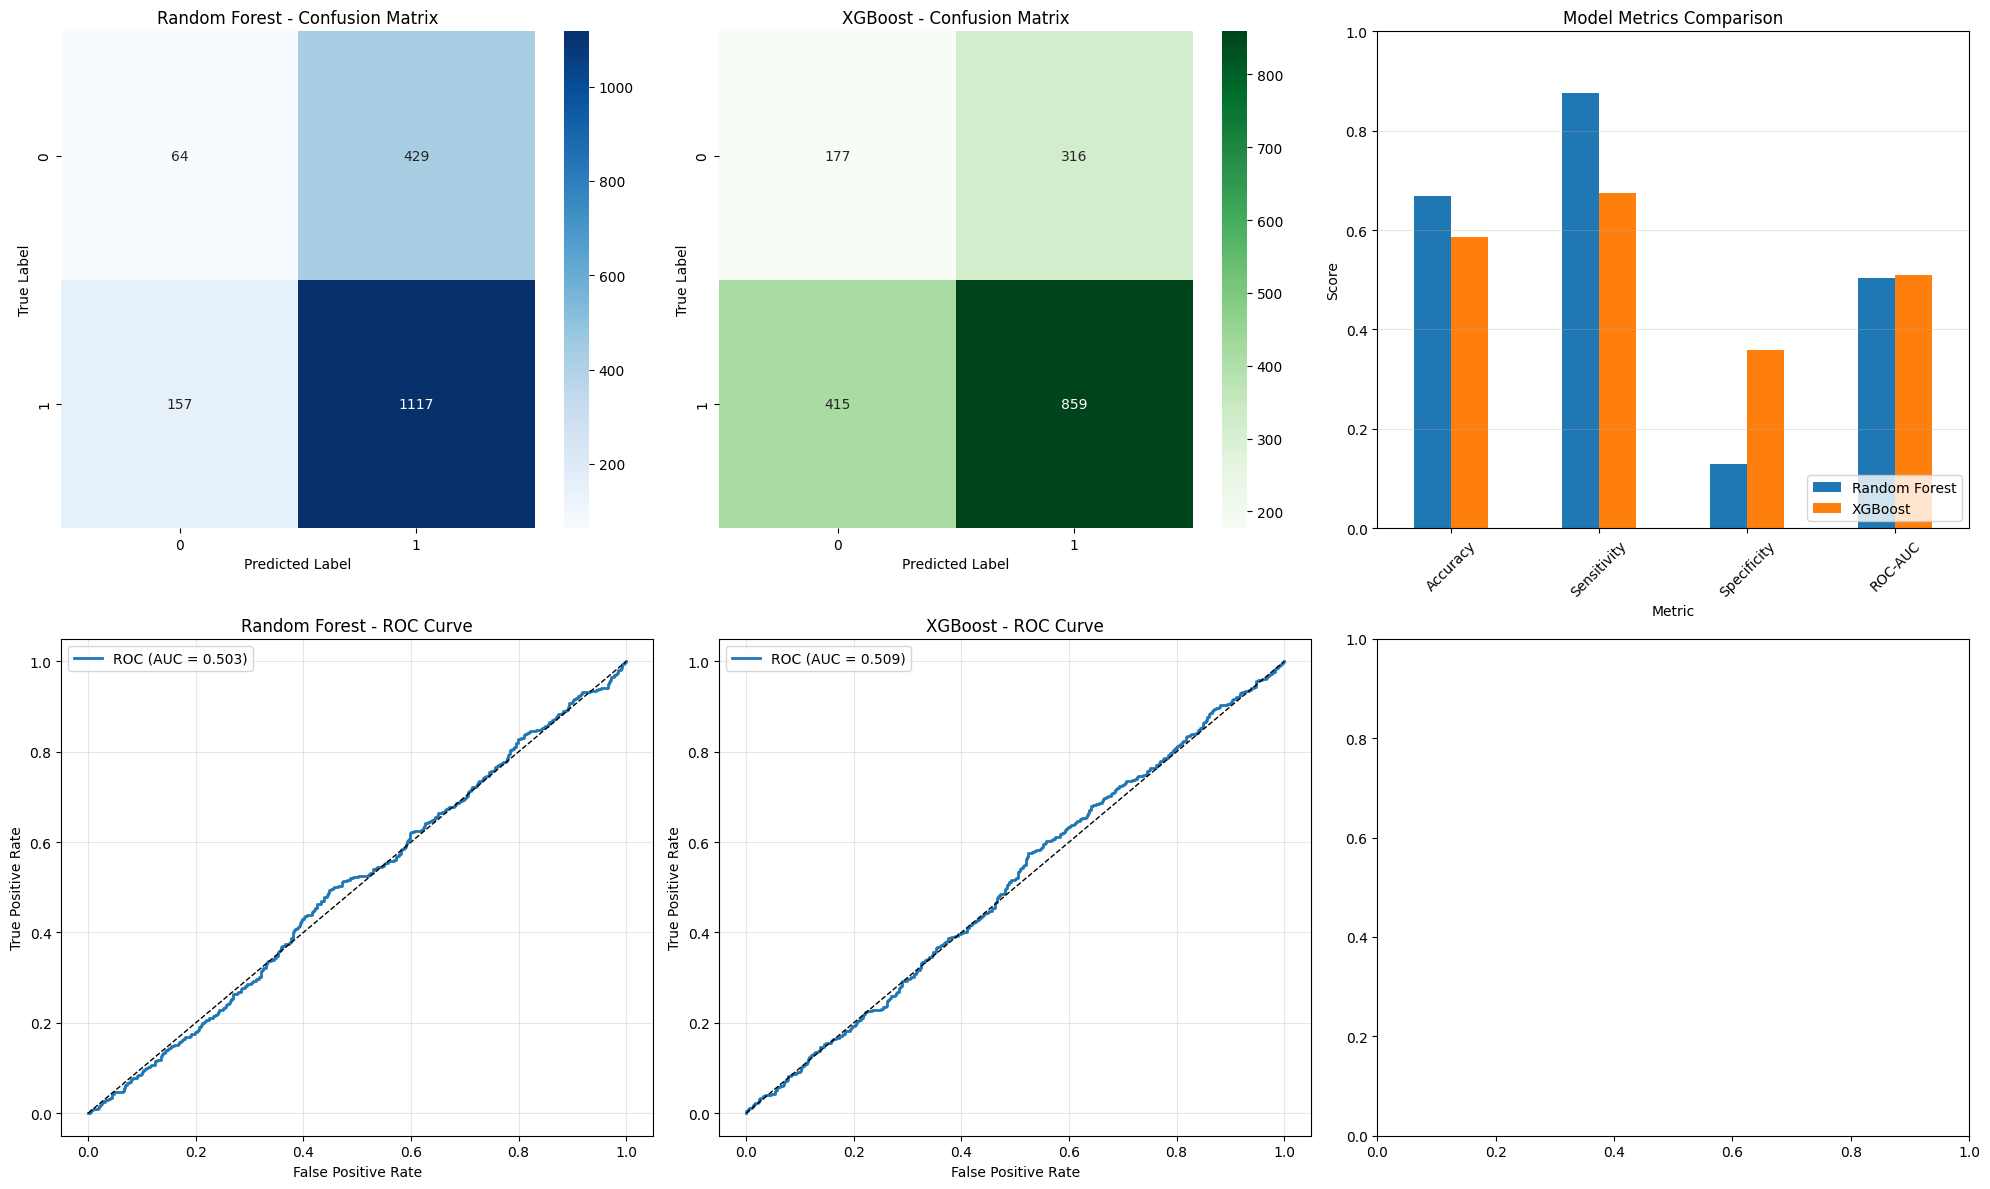

In [43]:
#subplot grid
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

#Confusion Matrix - Random Forest
sns.heatmap(
    rf_test_metrics['confusion_matrix'],
    annot=True,
    fmt='d',
    cmap='Blues',
    ax=axes[0, 0]
)
axes[0, 0].set_title('Random Forest - Confusion Matrix')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')

#Confusion Matrix - XGBoost
sns.heatmap(
    xgb_test_metrics['confusion_matrix'],
    annot=True,
    fmt='d',
    cmap='Greens',
    ax=axes[0, 1]
)
axes[0, 1].set_title('XGBoost - Confusion Matrix')
axes[0, 1].set_ylabel('True Label')
axes[0, 1].set_xlabel('Predicted Label')

#Metrics Comparison
metrics_comparison = comparison_df.set_index('Metric')
metrics_comparison.plot(kind='bar', ax=axes[0, 2], rot=45)
axes[0, 2].set_title('Model Metrics Comparison')
axes[0, 2].set_ylabel('Score')
axes[0, 2].set_ylim(0, 1)
axes[0, 2].grid(axis='y', alpha=0.3)
axes[0, 2].legend(loc='lower right')

#ROC Curve - Random Forest (binary only)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_pred_proba_rf)
axes[1, 0].plot(
    fpr_rf, tpr_rf, lw=2,
    label=f'ROC (AUC = {rf_test_metrics["roc_auc"]:.3f})'
)
axes[1, 0].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1, 0].set_title('Random Forest - ROC Curve')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

#ROC Curve - XGBoost (binary only)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_pred_proba_xgb)
axes[1, 1].plot(
    fpr_xgb, tpr_xgb, lw=2,
    label=f'ROC (AUC = {xgb_test_metrics["roc_auc"]:.3f})'
)
axes[1, 1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1, 1].set_title('XGBoost - ROC Curve')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


### Feature Importance

In [39]:
# Random Forest Feature Importance
rf_classifier = rf_model.named_steps['clf']
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance Random Forest")
print(feature_importance.to_string(index=False))

Feature Importance Random Forest
     feature  importance
         BMI    0.226006
 Systolic_BP    0.196460
         Age    0.189830
Diastolic_BP    0.183272
  Heart_Rate    0.174835
      Gender    0.029596


In [40]:
# XGBoost Feature Importance
xgb_classifier = xgb_model.named_steps['clf']
xgb_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance XGBoost")
print(xgb_feature_importance.to_string(index=False))

Feature Importance XGBoost
     feature  importance
 Systolic_BP    0.175542
         Age    0.173458
         BMI    0.172380
Diastolic_BP    0.166383
  Heart_Rate    0.166311
      Gender    0.145926


### Saving the models

In [44]:
os.makedirs('../models', exist_ok=True)

In [45]:
#saving random forest model
rf_model_path = '../models/random_forest_model.pkl'
joblib.dump(rf_model, rf_model_path)

#saving xgboost model
xgb_model_path = '../models/xgboost_model.pkl'
joblib.dump(xgb_model, xgb_model_path)


['../models/xgboost_model.pkl']

In [46]:
#sample data
sample_patients = pd.DataFrame({
    'Age': [35, 55, 45, 28, 65],
    'BMI': [24.5, 28.3, 32.1, 22.0, 26.8],
    'Systolic_BP': [118, 145, 135, 110, 155],
    'Diastolic_BP': [78, 92, 88, 72, 95],
    'Heart_Rate': [72, 85, 78, 68, 88],
    'Gender': [1, 0, 1, 0, 1]  # 1=Male, 0=Female
})

print("\nSample Patients:")
print(sample_patients)

# predictions with xgb_model
predictions = xgb_model.predict(sample_patients)
prediction_proba = xgb_model.predict_proba(sample_patients)

#results display
results = sample_patients.copy()
results['Prediction'] = predictions
results['Risk_Probability'] = prediction_proba[:, 1]
results['Risk_Level'] = results['Prediction'].map({0: 'No Hypertension', 1: 'Hypertension'})

print("\nPrediction Results:")
print(results[['Age', 'Systolic_BP', 'Diastolic_BP', 'Risk_Level', 'Risk_Probability']])



Sample Patients:
   Age   BMI  Systolic_BP  Diastolic_BP  Heart_Rate  Gender
0   35  24.5          118            78          72       1
1   55  28.3          145            92          85       0
2   45  32.1          135            88          78       1
3   28  22.0          110            72          68       0
4   65  26.8          155            95          88       1

Prediction Results:
   Age  Systolic_BP  Diastolic_BP    Risk_Level  Risk_Probability
0   35          118            78  Hypertension          0.585674
1   55          145            92  Hypertension          0.712573
2   45          135            88  Hypertension          0.732771
3   28          110            72  Hypertension          0.847053
4   65          155            95  Hypertension          0.588000


In [48]:
# prediction function for API integration
def predict_hypertension(age, bmi, systolic_bp, diastolic_bp, heart_rate, gender):
    """
    Simple prediction function for API integration
    
    Args:
        age: Patient age
        bmi: Body Mass Index
        systolic_bp: Systolic blood pressure
        diastolic_bp: Diastolic blood pressure
        heart_rate: Heart rate (bpm)
        gender: 1 for Male, 0 for Female
    
    Returns:
        dict with prediction and probability
    """
    # input dataframe
    input_data = pd.DataFrame({
        'Age': [age],
        'BMI': [bmi],
        'Systolic_BP': [systolic_bp],
        'Diastolic_BP': [diastolic_bp],
        'Heart_Rate': [heart_rate],
        'Gender': [gender]
    })
    
    # make prediction
    prediction = xgb_model.predict(input_data)[0]
    probability = xgb_model.predict_proba(input_data)[0, 1]
    
    # mapping to risk level
    if systolic_bp >= 140 or diastolic_bp >= 90:
        risk_level = "high"
    elif systolic_bp >= 120 or diastolic_bp >= 80:
        risk_level = "medium"
    else:
        risk_level = "low"
    
    return {
        'hypertension_predicted': bool(prediction),
        'probability': float(probability),
        'risk_level': risk_level,
        'confidence': float(max(xgb_model.predict_proba(input_data)[0]))
    }

# testing the function

print("Testing Prediction Function")

test_result = predict_hypertension(
    age=45,
    bmi=28.5,
    systolic_bp=135,
    diastolic_bp=88,
    heart_rate=78,
    gender=1
)

print("\nTest Input: Age=45, BMI=28.5, SBP=135, DBP=88, HR=78, Gender=Male")
print(f"Result: {test_result}")

TESTING PREDICTION FUNCTION

Test Input: Age=45, BMI=28.5, SBP=135, DBP=88, HR=78, Gender=Male
Result: {'hypertension_predicted': True, 'probability': 0.8223367929458618, 'risk_level': 'medium', 'confidence': 0.8223367929458618}
